# 🏞 Smoker detection using Convolutional Neural Networks

In [3]:
import tensorflow as tf
import keras

# Define required variables
data_dir = "smoking/Training"  # Path to training data
img_height = 180
img_width = 180
batch_size = 32

# Load and preprocess images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 716 files belonging to 2 classes.
Using 573 files for training.


### Goal:
- Develop a convolutional neural network (CNN) that accurately predicts whether a person in a photo is smoking.

**Dataset used**: [Smoker Detection Classification Dataset](https://www.kaggle.com/datasets/sujaykapadnis/smoking/data) (Kaggle)

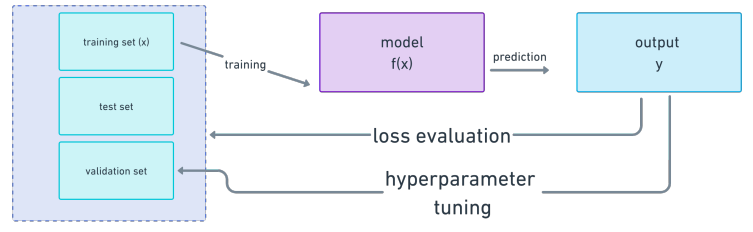


*figure from ["What are embeddings?"](https://vickiboykis.com/what_are_embeddings/) PDF*

## Libraries and Packages
First up, we're loading all necessary packages for managing our image dataset, constructing, training, and evaluating our model. We're also using [Weights and Biases](https://wandb.ai/site), a fantastic tool for tracking and visualizing our model's performance.

In [4]:
!pip install wandb -qU 
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt

In the code below we are logging in to Weights and Biases through their API.

In [7]:
# Import required libraries
import wandb

# Login to wandb with API key
wandb.login(key="f950eec4173fb691759b0209520cdf833756e4f6")

# Initialize wandb project
wandb.init(
    project="Smoker_Detection",  # Matches repository name from README.md
    entity="kyledolce",
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "batch_size": 32,
        "img_height": 250,
        "img_width": 250
    }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\User\_netrc


CommError: Run initialization has timed out after 90.0 sec. Please try increasing the timeout with the `init_timeout` setting: `wandb.init(settings=wandb.Settings(init_timeout=120))`.

In [ ]:
# Setting up a random seed for reproducibility
tf.random.set_seed(42)

## Prepare the Data <a name="prepare"></a>

Here, we connect to Google Drive, specify our dataset directories, and load the data.

### Connect Google Drive

In [ ]:
from google.colab import drive

# This will prompt for authorization and mount your drive.
drive.mount('/content/drive')

# This is the path to our dataset.
dataset_path = '/content/drive/MyDrive/ML_experiments/smoking'

print("Dataset is located at:", dataset_path)

Mounted at /content/drive
Dataset is located at: /content/drive/MyDrive/ML_experiments/smoking


### Specify directories
Our dataset is structured as follows, ensuring organized access to training, testing, and validation images:

```
├── smoking
│   ├── Training
│   │   ├── Smoking
│   │   └── Not Smoking
│   ├── Testing
│   │   ├── Smoking
│   │   └── Not Smoking
│   └── Validation
│       ├── Smoking
│       └── Not Smoking
```

In [2]:
import os
import tensorflow as tf
import keras

# Define directory paths
train_dir = 'smoking/Training/'
test_dir = 'smoking/Testing/'
val_dir = 'smoking/Validation/'

# Set image parameters
img_height = 180
img_width = 180
batch_size = 32

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Verify directory contents
print("Contents of train directory:", os.listdir(train_dir))
print("Contents of test directory:", os.listdir(test_dir))
print("Contents of validation directory:", os.listdir(val_dir))

Found 716 files belonging to 2 classes.
Using 573 files for training.
Found 180 files belonging to 2 classes.
Found 224 files belonging to 2 classes.
Contents of train directory: ['Not Smoking', 'Smoking']
Contents of test directory: ['Not Smoking', 'Smoking']
Contents of validation directory: ['Not Smoking', 'Smoking']


### Load and Pre-process dataset
We load our images using TensorFlow's `image_dataset_from_directory`, specifying image size (250x250), batch size (64), and shuffling options.

In [4]:
# Load datasets from directories
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(250, 250),
    batch_size=64, # model 10
    shuffle=True  # Explicitly shuffle the training dataset
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(250, 250),
    batch_size=64, # model 10
    shuffle=False  # No need to shuffle the test dataset
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(250, 250),
    batch_size=64, # model 10
    shuffle=False  # No need to shuffle the validation dataset
)

Found 716 files belonging to 2 classes.
Found 224 files belonging to 2 classes.
Found 180 files belonging to 2 classes.


### One-hot encoding
To convert our categorical labels ('smoking', 'not smoking') into a format understandable by the model, we use "One-hot encoding". This technique transforms categorical values into a binary vector representation, which is crucial for our model's learning process.

In [5]:
# Preprocess data to match the output shape of the model's loss function
NUM_CLASSES = 2 # the number of classes (smoking, not smoking)

def preprocess(image, label):
    return image, tf.one_hot(label, depth=NUM_CLASSES)

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Then, we visualize the dataset to ensure that the labels are showing up correctly.

Found 716 files belonging to 2 classes.
Using 573 files for training.
Found 180 files belonging to 2 classes.


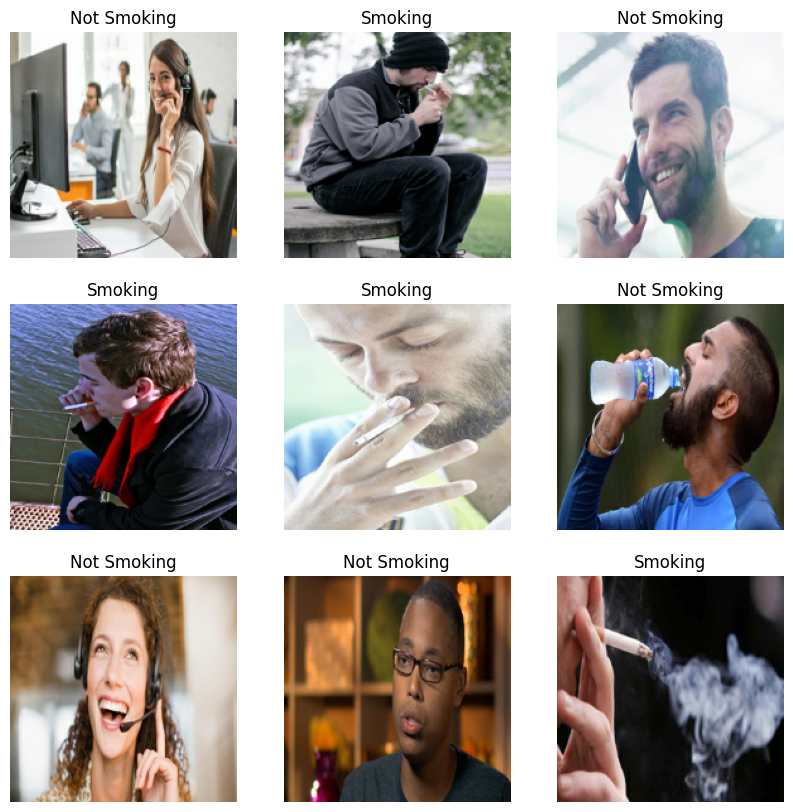

In [9]:
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np  # Changed from 'import np' to 'import numpy as np'

# Define directory paths
train_dir = 'smoking/Training/'
test_dir = 'smoking/Testing/'
val_dir = 'smoking/Validation/'

# Set image parameters
img_height = 180
img_width = 180
batch_size = 32

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names from the dataset
class_names = train_ds.class_names

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Build the model <a name="build"></a>

I've made about ~37 models with different hyperparameters. In the interest of simplicity I'm going to show the most performant model so far which is Model 29 (my 29th attempt).

### Model 1 - First Attempt
Initially, I adapted a CNN structure from *Generative Deep Learning (2nd Edition)*, adding a normalization layer for consistent data scaling. This model, complex with its 32 million parameters, was our starting point.

In [11]:
# Required imports
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Directory and image parameters setup
train_dir = 'smoking/Training/'
test_dir = 'smoking/Testing/'
val_dir = 'smoking/Validation/'
img_height = 250
img_width = 250
batch_size = 32

# Build the CNN model
input_layer = layers.Input((250, 250, 3))  # 250x250 pixels, RGB images

# Model architecture
x = layers.Rescaling(1./255)(input_layer)  # Normalization
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(2, activation='softmax')(x)

# Create the model
model = keras.Model(input_layer, output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,444,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501,250 (13.36 MB)

 Trainable params: 3,501,250 (13.36 MB)

 Non-trainable params: 0 (0.00 B)

### Model 29 - The Latest Iteration
To address overfitting (where the model performs well on training data but poorly on unseen data), I experimented with hyperparameter adjustments. The final model, with around 70k parameters, is simpler and more effective, demonstrating the power of iterative improvement in model development.




In [13]:
# Required imports
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models  # Added models import
import matplotlib.pyplot as plt
import numpy as np

# Constants
NUM_CLASSES = 2
IMG_HEIGHT = 250
IMG_WIDTH = 250
BATCH_SIZE = 32

# Build the CNN model
input_layer = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))

# Model architecture
x = layers.Rescaling(1./255)(input_layer)  # Normalization
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

# Create model
model = models.Model(input_layer, output_layer)

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,444,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501,250 (13.36 MB)

 Trainable params: 3,501,250 (13.36 MB)

 Non-trainable params: 0 (0.00 B)

Our model has about 70k parameters that will be updated in the training process. A huge difference from Model 1 which had roughly 32M parameters! This means the model we have now is a much more simpler model.



### Here's a visual of our model

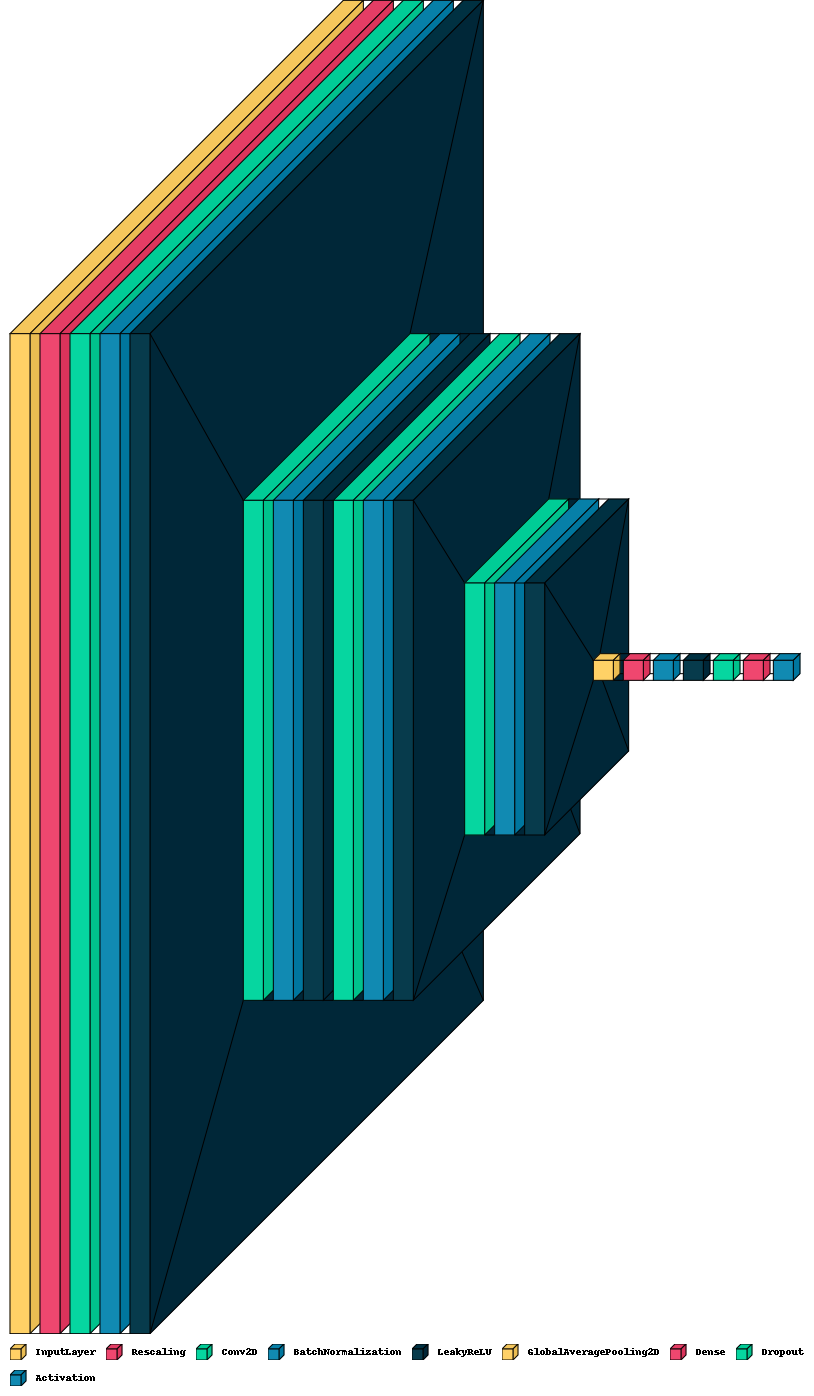

## Metrics and Callbacks


Here's how we're monitoring and enhancing our model's performance:

- **Weights and Biases**: For real-time tracking of metrics like accuracy and loss, with an intuitive dashboard.
- **Checkpoints**: We save snapshots of the model's state during training. This helps us revert to the best-performing version if needed.
- **Early Stopping**: Training halts when the model stops improving, preventing overfitting.

### Initializing Weights and Biases training run

In [ ]:
# Required imports
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import wandb  # Add wandb import

# Initialize W&B
wandb.init(
    project='smoking-0',
    entity='redito',
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "batch_size": 32,
        "img_height": 250,
        "img_width": 250
    }
)

# Get configuration
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# Creating checkpoint to ensure model state is saved at end of each epoch
# when a certain performance criterion is met (eg. validation loss)

from datetime import datetime

# Create a unique name for the model using the current date and time
model_name = 'model_29_' + datetime.now().strftime("%Y%m%d-%H%M%S")

# Checkpoint path
checkpoint_path = f'/content/drive/MyDrive/ML_experiments/smoking/{model_name}.h5'

# Create a model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,  # Use the checkpoint_path variable
    monitor='val_loss',     # Monitor validation loss
    verbose=1,              # Logging level
    save_best_only=True,    # Save only the best model
    mode='min'              # Minimization mode for monitored quantity
)

# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# W&B callback
wandb_callback = wandb.keras.WandbCallback()

## Train the model <a name="train"></a>

We explore various training options, tweaking optimizers, and experimenting with learning rates for optimal performance.

### Option 1 - Starting point

This was the code that came with the book. The default metric to track was accuracy but I took the liberty of adding `Precision` and `Recall` to give more nuance in my understanding of the results.

In [ ]:
# Set optimizer
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy",
                                                             Precision(),
                                                             Recall()] # added precision and recall as metrics
)

# Training
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=(val_dataset),
    callbacks=[checkpoint_callback, wandb_callback]
)

# Stop W&B run
wandb.finish()

### Option 2 - Learning rate (Exponential Decay)
We employed an Exponential Decay strategy for the learning rate, starting with larger steps and gradually reducing them. This approach helps in fine-tuning the model parameters more effectively.

*Below is some code to speed up calculation of decay steps. This is not part of the training code. It's here for my convenience.*

### Decay steps calculator

In [ ]:
# Calculate steps per epoch for training data and setting decay steps
import math

# Total number of training samples
total_training_samples = 716

# Batch size
batch_size = 64 # changed to 64

# Calculate the number of steps per epoch
steps_per_epoch = math.ceil(total_training_samples / batch_size)

# Decide on decay steps
# For example, to decay the learning rate every epoch:
decay_steps_reco = steps_per_epoch
print(decay_steps_reco)

# Or, to decay every two epochs (for a slower decay):
# decay_steps = 2 * steps_per_epoch


12


### Defining learning rate

In [ ]:
# Define initial learning rate
initial_learning_rate = 0.0005 # model 29 lr
# initial_learning_rate = 0.0001 # Model 8 learning rate
# initial_learning_rate = 0.001 # model 20 learning rate

# Set up exponential decay function
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=12,   # Adjust this based on your dataset size and batch size, calculated above
    decay_rate=0.9,     # Adjust this based on how rapidly you want to reduce the learning rate
    staircase=True      # Use staircase decay for discrete intervals; set to False for continuous decay
)

### Optimizer

In [ ]:
# Set optimizer with exponential decay
opt = optimizers.Adam(learning_rate=lr_schedule)

### Model compile

In [ ]:
# Compile the model with the optimizer
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy", Precision(), Recall()]
)

### Run Training

In [ ]:
# Training with callbacks
history = model.fit(
    train_dataset,
    epochs=10, # for model 18 im setting this to 20 from 10
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, wandb_callback]
)

Epoch 1/10
 6/12 [==============>...............] - ETA: 1s - loss: 0.6871 - accuracy: 0.6849 - precision_2: 0.6849 - recall_2: 0.6849

12/12 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7081 - precision_2: 0.7081 - recall_2: 0.7081
Epoch 1: val_loss improved from inf to 0.62439, saving model to /content/drive/MyDrive/ML_experiments/smoking/model_29_20240111-203606.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240111_203552-76ri82i9/files/model-best)... Done. 0.0s


12/12 [==============================] - 13s 687ms/step - loss: 0.6319 - accuracy: 0.7081 - precision_2: 0.7081 - recall_2: 0.7081 - val_loss: 0.6244 - val_accuracy: 0.7389 - val_precision_2: 0.7389 - val_recall_2: 0.7389
Epoch 2/10
11/12 [==========================>...] - ETA: 0s - loss: 0.5998 - accuracy: 0.7273 - precision_2: 0.7273 - recall_2: 0.7273
Epoch 2: val_loss improved from 0.62439 to 0.58712, saving model to /content/drive/MyDrive/ML_experiments/smoking/model_29_20240111-203606.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240111_203552-76ri82i9/files/model-best)... Done. 0.0s


12/12 [==============================] - 7s 511ms/step - loss: 0.6015 - accuracy: 0.7263 - precision_2: 0.7263 - recall_2: 0.7263 - val_loss: 0.5871 - val_accuracy: 0.7278 - val_precision_2: 0.7278 - val_recall_2: 0.7278
Epoch 3/10
11/12 [==========================>...] - ETA: 0s - loss: 0.6114 - accuracy: 0.7287 - precision_2: 0.7287 - recall_2: 0.7287
Epoch 3: val_loss did not improve from 0.58712
12/12 [==============================] - 5s 288ms/step - loss: 0.6101 - accuracy: 0.7291 - precision_2: 0.7291 - recall_2: 0.7291 - val_loss: 0.6053 - val_accuracy: 0.7389 - val_precision_2: 0.7389 - val_recall_2: 0.7389
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.7235 - precision_2: 0.7235 - recall_2: 0.7235
Epoch 4: val_loss did not improve from 0.58712
12/12 [==============================] - 4s 275ms/step - loss: 0.5889 - accuracy: 0.7235 - precision_2: 0.7235 - recall_2: 0.7235 - val_loss: 0.6240 - val_accuracy: 0.7222 - val_precision_2: 0.7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240111_203552-76ri82i9/files/model-best)... Done. 0.0s


12/12 [==============================] - 8s 625ms/step - loss: 0.6183 - accuracy: 0.7207 - precision_2: 0.7207 - recall_2: 0.7207 - val_loss: 0.5502 - val_accuracy: 0.7333 - val_precision_2: 0.7333 - val_recall_2: 0.7333
Epoch 6/10
11/12 [==========================>...] - ETA: 0s - loss: 0.5953 - accuracy: 0.7216 - precision_2: 0.7216 - recall_2: 0.7216
Epoch 6: val_loss did not improve from 0.55018
12/12 [==============================] - 5s 290ms/step - loss: 0.5906 - accuracy: 0.7263 - precision_2: 0.7263 - recall_2: 0.7263 - val_loss: 0.5520 - val_accuracy: 0.7389 - val_precision_2: 0.7389 - val_recall_2: 0.7389
Epoch 7/10
12/12 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.7137 - precision_2: 0.7137 - recall_2: 0.7137
Epoch 7: val_loss improved from 0.55018 to 0.52062, saving model to /content/drive/MyDrive/ML_experiments/smoking/model_29_20240111-203606.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240111_203552-76ri82i9/files/model-best)... Done. 0.0s


12/12 [==============================] - 8s 649ms/step - loss: 0.6048 - accuracy: 0.7137 - precision_2: 0.7137 - recall_2: 0.7137 - val_loss: 0.5206 - val_accuracy: 0.7722 - val_precision_2: 0.7722 - val_recall_2: 0.7722
Epoch 8/10
11/12 [==========================>...] - ETA: 0s - loss: 0.5745 - accuracy: 0.7188 - precision_2: 0.7188 - recall_2: 0.7188
Epoch 8: val_loss did not improve from 0.52062
12/12 [==============================] - 4s 292ms/step - loss: 0.5728 - accuracy: 0.7207 - precision_2: 0.7207 - recall_2: 0.7207 - val_loss: 0.5340 - val_accuracy: 0.7556 - val_precision_2: 0.7556 - val_recall_2: 0.7556
Epoch 9/10
12/12 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.7137 - precision_2: 0.7137 - recall_2: 0.7137
Epoch 9: val_loss did not improve from 0.52062
12/12 [==============================] - 6s 365ms/step - loss: 0.6237 - accuracy: 0.7137 - precision_2: 0.7137 - recall_2: 0.7137 - val_loss: 0.5551 - val_accuracy: 0.7389 - val_precision_2: 0.7

## Evaluation <a name="evaluate"></a>

Post-training, we assess our model's performance, aiming for high accuracy and low loss.

In [ ]:
# After model training and validation
test_results = model.evaluate(test_dataset)

# test_results[0] is loss, test_results[1] is accuracy,
# and you have additional metrics like precision and recall
test_loss = test_results[0]
test_accuracy = test_results[1]
# If you have other metrics like precision and recall, you can access them similarly
# For example: test_precision = test_results[2], test_recall = test_results[3]

# Log test metrics
wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Stop W&B run
wandb.finish()

4/4 [==============================] - 1s 75ms/step - loss: 0.5702 - accuracy: 0.7277 - precision_2: 0.7277 - recall_2: 0.7277
Test Loss: 0.5702370405197144
Test Accuracy: 0.7276785969734192


accuracy,▂▇█▇▆▇▄▆▄▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▅▃▆▃▅▁▇▃
precision_2,▂▇█▇▆▇▄▆▄▁
recall_2,▂▇█▇▆▇▄▆▄▁
test_accuracy,▁
test_loss,▁
val_accuracy,▃▂▃▁▃▃█▆▃▃
val_loss,█▅▇█▃▃▁▂▃▂
val_precision_2,▃▂▃▁▃▃█▆▃▃
val_recall_2,▃▂▃▁▃▃█▆▃▃



[Here's all the metrics for my top 5 most performant models
](https://api.wandb.ai/links/redito/olzgfqet)

## Inference

Finally, we test our model with new images, observing its ability to generalize.

### Load model artifact from Google Drive

Remember that the model artifacts were saved in Weights and Biases. I downloaded the most performant model (model 29) and uploaded them to my google drive. In the code below, we are loading the model to make predictions.

In [ ]:
model_directory = '/content/drive/MyDrive/ML_experiments/smoking/model_29'

# Load the model from that directory
model = tf.keras.models.load_model(model_directory)

# Now the model is ready to make predictions
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 250, 250, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 250, 250, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                             

### Make predictions

To make predictions, we load a new set of images, ones that weren't seen by the model before, and feed that into model. We will see the output and what it thinks the images contain: a person smoking or not smoking?

### Preprocessing new images and predict

To ensure that the model sees the images correctly we pre-process the new images in exactly the same way we pre-processed the images during training.

Then, we use `model.predict` on the new images.

Found 18 files belonging to 2 classes.
1/1 [==============================] - 0s 143ms/step
Image 1 - Probability of Smoking: 0.54, Probability of Not Smoking: 0.46
1/1 [==============================] - 0s 20ms/step
Image 2 - Probability of Smoking: 0.38, Probability of Not Smoking: 0.62
1/1 [==============================] - 0s 22ms/step
Image 3 - Probability of Smoking: 0.87, Probability of Not Smoking: 0.13
1/1 [==============================] - 0s 18ms/step
Image 4 - Probability of Smoking: 0.04, Probability of Not Smoking: 0.96
1/1 [==============================] - 0s 20ms/step
Image 5 - Probability of Smoking: 0.88, Probability of Not Smoking: 0.12
1/1 [==============================] - 0s 22ms/step
Image 6 - Probability of Smoking: 0.90, Probability of Not Smoking: 0.10
1/1 [==============================] - 0s 19ms/step
Image 7 - Probability of Smoking: 0.47, Probability of Not Smoking: 0.53
1/1 [==============================] - 0s 19ms/step
Image 8 - Probability of Smoking:

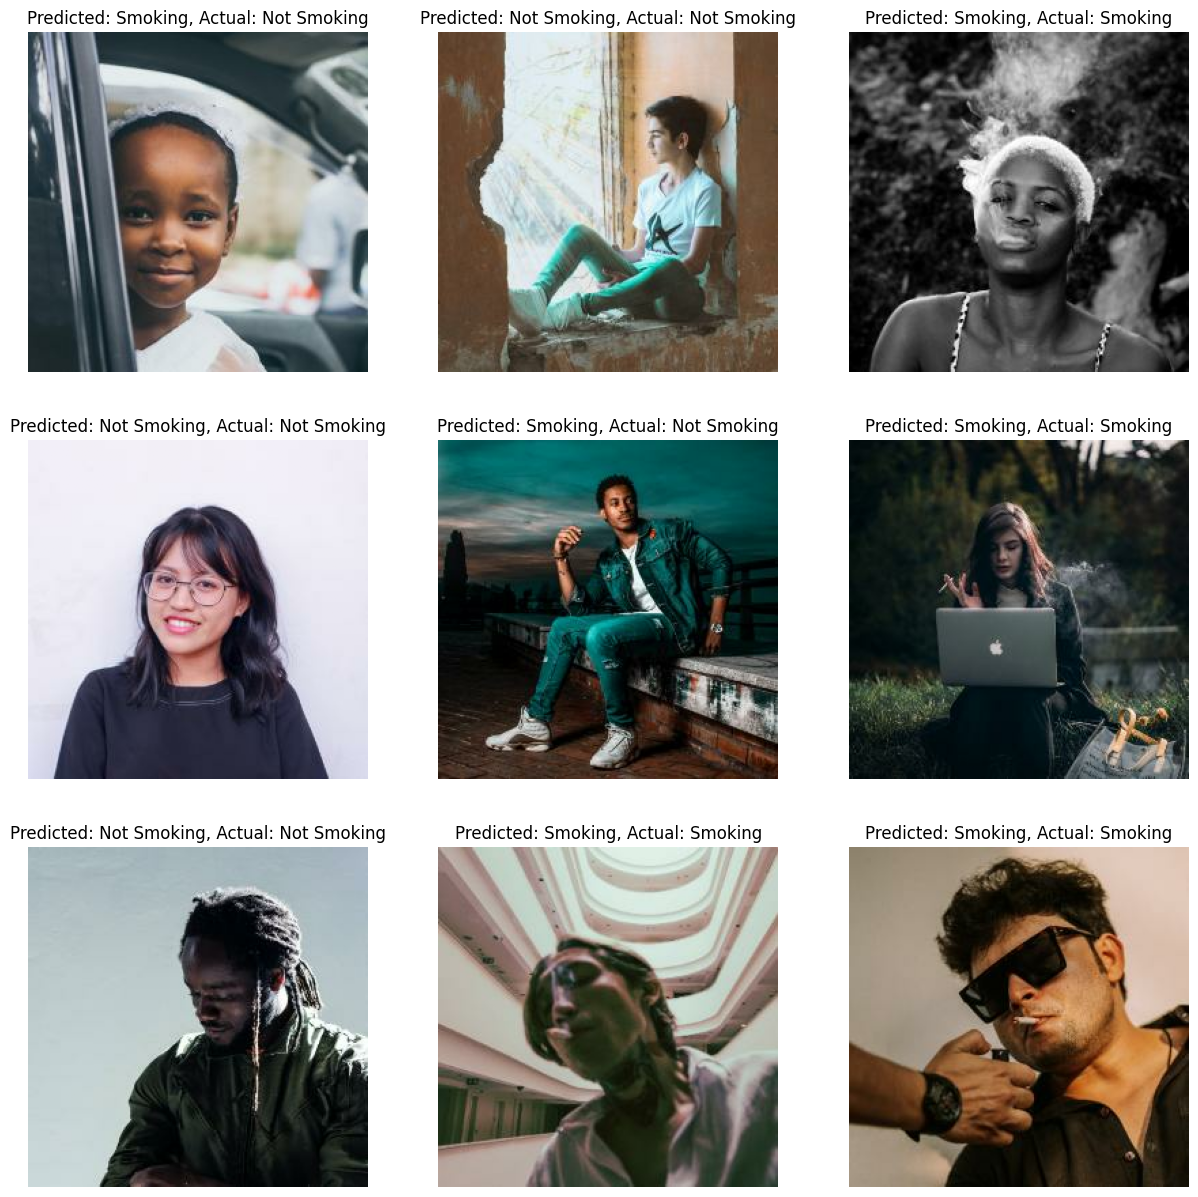

In [ ]:
# Path to new images
new_data_dir = '/content/drive/MyDrive/ML_experiments/smoking/new_images'

new_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_data_dir,
    image_size=(250, 250),
    batch_size=1,  # Set batch size to 1 for individual prediction
    shuffle=True
)

# Display images with predictions
plt.figure(figsize=(15, 15))
for idx, (images, labels) in enumerate(new_dataset.take(9)):  # Take only 9 images
    ax = plt.subplot(3, 3, idx + 1)

    # Normalize images for display
    display_image = images[0].numpy().astype("float32") / 255.0
    plt.imshow(display_image)

    predictions = model.predict(images)
    predicted_class = np.argmax(predictions)
    actual_class = np.argmax(labels.numpy()) if len(labels.shape) > 1 else labels.numpy()[0]

    # Setting title to show predicted and actual labels
    ax.set_title(f"Predicted: {'Smoking' if predicted_class == 1 else 'Not Smoking'}, Actual: {'Smoking' if actual_class == 1 else 'Not Smoking'}")
    plt.axis("off")

    # Get prediction probabilities
    prediction_probs = predictions[0]
    prob_smoking = prediction_probs[1]
    prob_not_smoking = prediction_probs[0]

    # Print the probabilities for each class
    print(f"Image {idx+1} - Probability of Smoking: {prob_smoking:.2f}, Probability of Not Smoking: {prob_not_smoking:.2f}")
plt.show()


### Reflections on Model Predictions

After testing our model with 9 new images, here are some intriguing insights:

1. **Performance Overview**: The model incorrectly predicted 2 out of the 9 images. Specifically, it stumbled on Image 1 (a young girl) and Image 5 (a young man in a denim jacket).

2. **Human vs. Model Perception**: For us, it's straightforward to discern whether someone is smoking in a photo. However, for a neural network, it's a complex task of identifying and interpreting features. Let's delve a little deeper:

    - **Image 1 Analysis**: To us, it's clear the young girl isn't smoking. However, the bokeh effect in the background might resemble smoke to the model. This misinterpretation is reflected in the model's nearly 50/50 probability split, indicating its uncertainty.

    - **Image 5 Analysis**: The model confidently (88% probability) mistook the young man as smoking. A closer look reveals why – his hand position resembles that of holding a cigarette. It's a fascinating example of how models can misinterpret visual cues.

3. **Understanding Model Limitations**: These observations highlight the complexity of our task. Distinguishing smoking from non-smoking in images is more challenging than it appears, and the model can get confused by certain visual elements.

4. **Evaluating Accuracy**: With an accuracy of around 70%, our model is correct most of the time. Given the intricacies of this task, this level of accuracy is quite commendable. It shows that while not perfect, our model has a strong understanding of the key features indicative of smoking.


## Conclusion: A Journey in Image Classification

As we wrap up this notebook, let's take a moment to reflect on our journey through the intricate world of image classification using Convolutional Neural Networks (CNNs) for smoker detection.

**Key Takeaways**:
1. **Model Development**: Starting from a complex model with over 32 million parameters, we iteratively refined our approach to create a more efficient model with around 70k parameters. This process underscored the importance of hyperparameter tuning and model simplification in achieving better generalization.

2. **Challenges and Learning**: We encountered and overcame challenges like overfitting and learned about the subtleties of image recognition. Our model's misinterpretations on certain test images provided valuable insights into how CNNs perceive and process visual data.

3. **Achievements**: With an accuracy of approximately 70%, our model demonstrated a solid capability in identifying smoking behavior from images. This is a significant achievement, considering the complexity of the task and the nuances involved in visual data interpretation.



**Final Thoughts**:
This project was not just about building an accurate model; it was a journey of learning, experimenting, and understanding the nuances of machine learning. I am excited about the endless possibilities that lie ahead in the realm of AI. I hope this notebook serves as a  resource and a stepping stone for further exploration and learning.
